# Classifying the type of flooring surface using data collected by Inertial Measurement Units sensors

Author: Patrick Alves (cpatrickalves@gmail.com)
Date: 09/23/2019

Data source: Tampere University Signal Processing Department in Finland.

Competition page: https://www.kaggle.com/c/competicao-dsa-machine-learning-sep-2019/

## Exploratory Data Analysis

The sensor data collected includes accelerometer data, gyroscope data (angular
rate) and internally estimated orientation. Specifically:

* Orientation: 4 attitude quaternion (a mathematical notation used to represent orientations and rotations in a 3D space) channels, 3 for vector part and one for scalar part;
* Angular rate: 3 channels, corresponding to the 3 IMU coordinate axes X, Y, and Z;
* Acceleration: 3 channels, specific force corresponding to 3 IMU coordinate axes X, Y, and Z.

Each data point includes the measures described above of orientation, velocity and acceleration, resulting in a feature vector of length 10 for each point.

There are 128 measurements per time series plus three identification columns:
* ***row_id***: The ID for the row.
* ***series_id***: a number that identify the measurement series. It is also the foreign key to **y_train** and sample_submission.
* ***measurement_number***: measurement number within the series.


#### Loading the data

In [1]:
# If you will use tqdm
#!pip install ipywidgets 
#!jupyter nbextension enable --py widgetsnbextension

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [3]:
# Folder with datasets
data_folder = "data/"

# Running on kaggle?
kaggle = False

if kaggle:
    data_folder = "../input/"

# Load the data for training ML models
xtrain = pd.read_csv(data_folder + "X_treino.csv")
ytrain = pd.read_csv(data_folder + "y_treino.csv")
train_data = pd.merge(xtrain, ytrain, how = "left", on = "series_id")

#Load the Test dataset to predict the results
xtest = pd.read_csv(data_folder + "X_teste.csv")
test_data = xtest

# Showing the number of samples and columns for each dataset
print(train_data.shape)
print(test_data.shape)

(487680, 15)
(488448, 13)


In [4]:
train_data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


In [5]:
test_data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


#### Frequency Distribution 

Number of  time series in train dataset: 3810
Number of  time series in test dataset: 3816

Surfaces frequency distribution in train dataset:
concrete                  99712
soft_pvc                  93696
wood                      77696
tiled                     65792
fine_concrete             46464
hard_tiles_large_space    39424
soft_tiles                38016
carpet                    24192
hard_tiles                 2688
Name: surface, dtype: int64


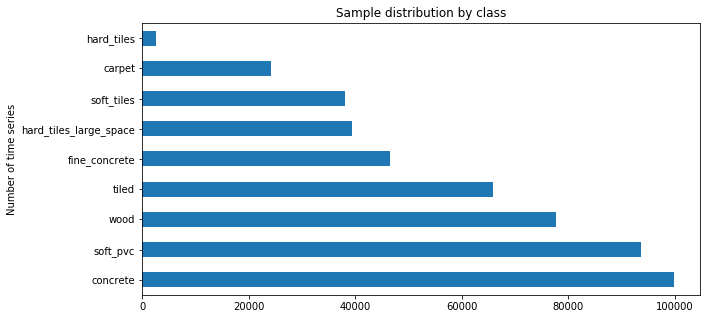

In [6]:
# Check unique values
train_count_series = len(train_data.series_id.unique())
test_count_series = len(test_data.series_id.unique())
train_freq_distribution_surfaces = train_data.surface.value_counts()

print(f"Number of  time series in train dataset: {train_count_series}")
print(f"Number of  time series in test dataset: {test_count_series}\n")

print(f"Surfaces frequency distribution in train dataset:\n{train_freq_distribution_surfaces}")
train_freq_distribution_surfaces.plot(kind="barh", figsize=(10,5))
plt.title("Sample distribution by class")
plt.ylabel("Number of time series")
plt.show()

So, the train data set contains 3810 labeled time series samples, with the corresponding surface type annotation. 

Most of the samples are for the concrete surface. The *hard_tiles* has only 2688 samples, this may be insufficient to build a robust model for this type of surface.

Furthermore, the classes are not balanced so we need to be careful because simple accuracy score is not enough to evaluate the model performance.

#### Frequency distribution for each column

<Figure size 432x288 with 0 Axes>

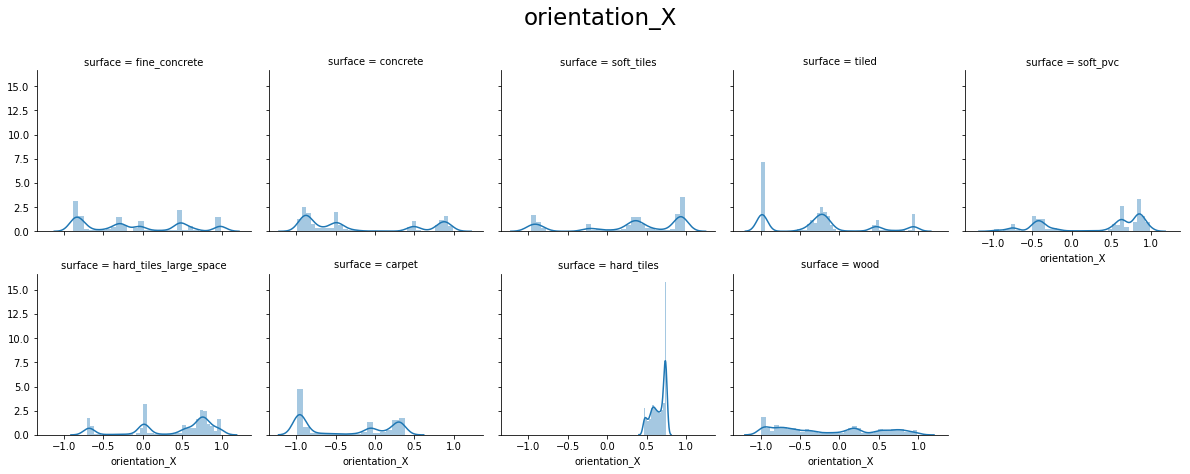

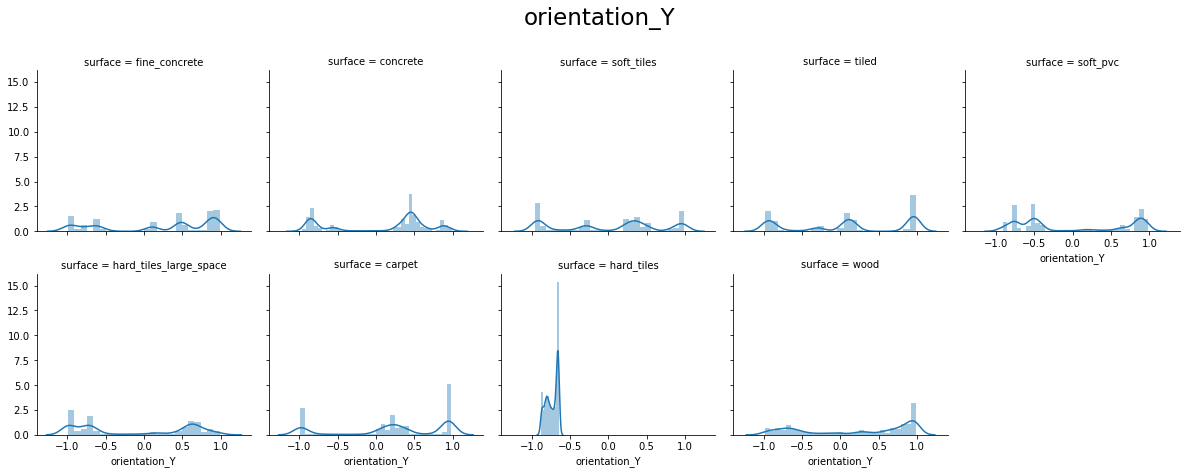

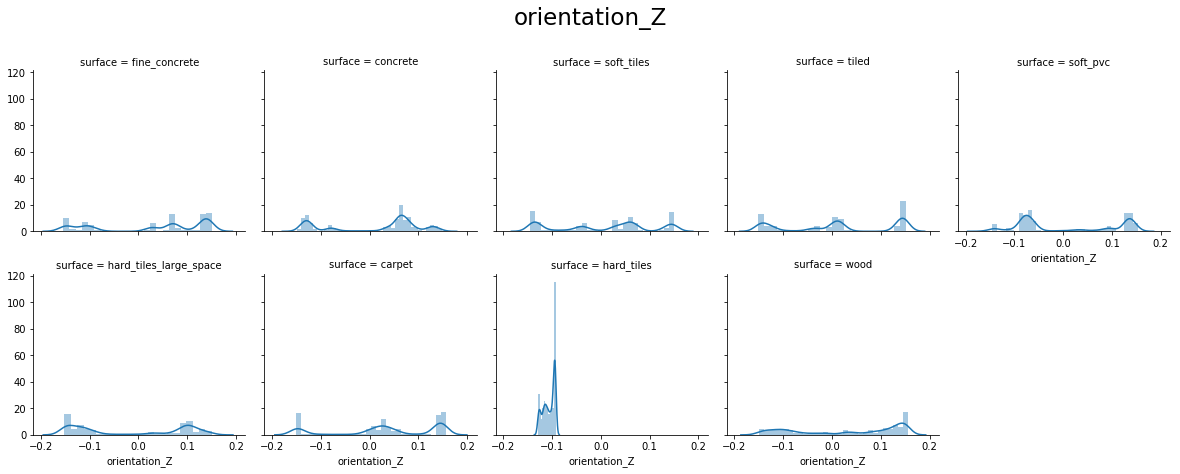

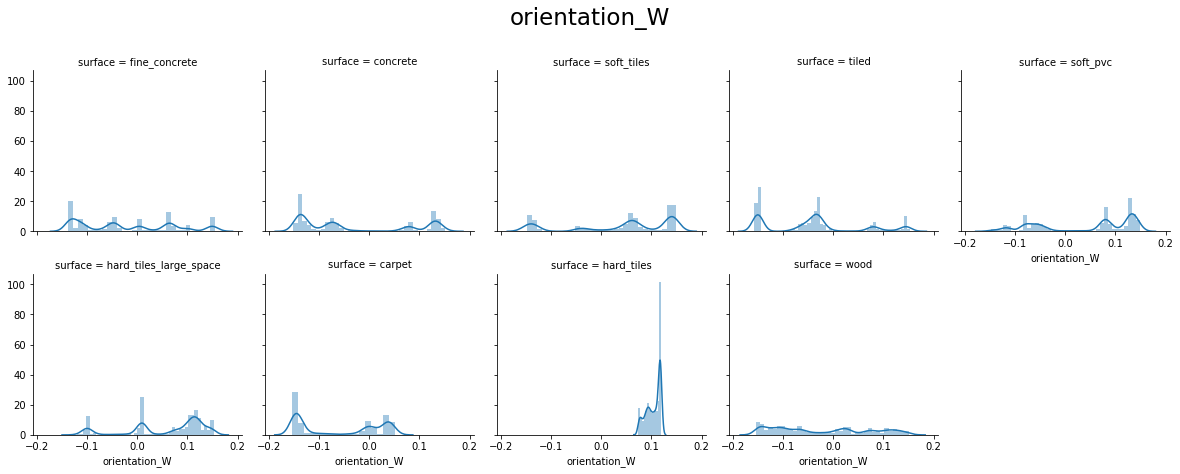

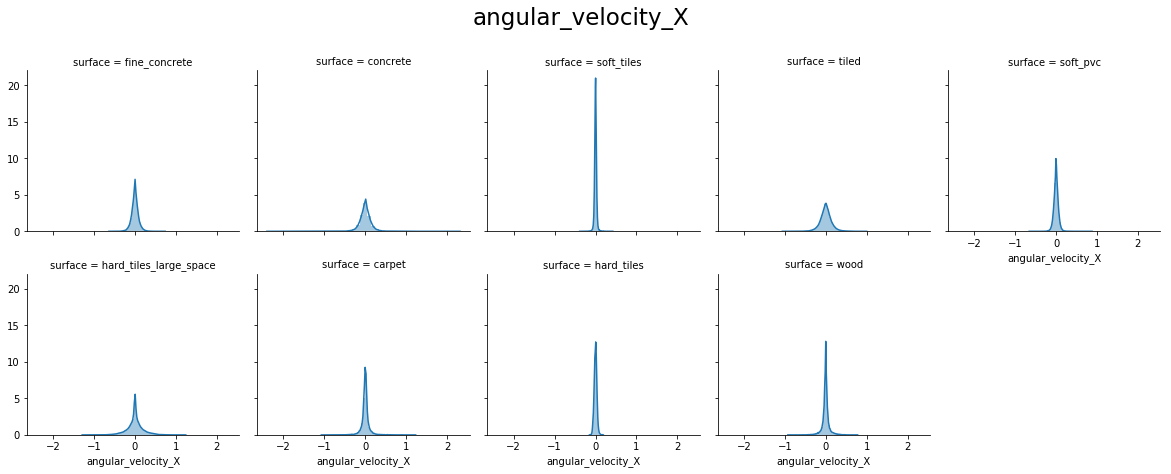

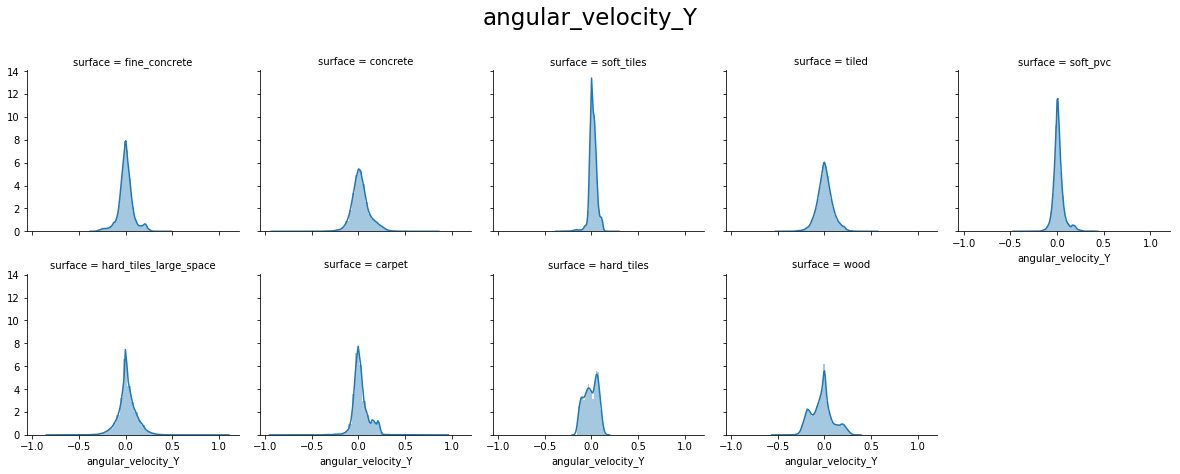

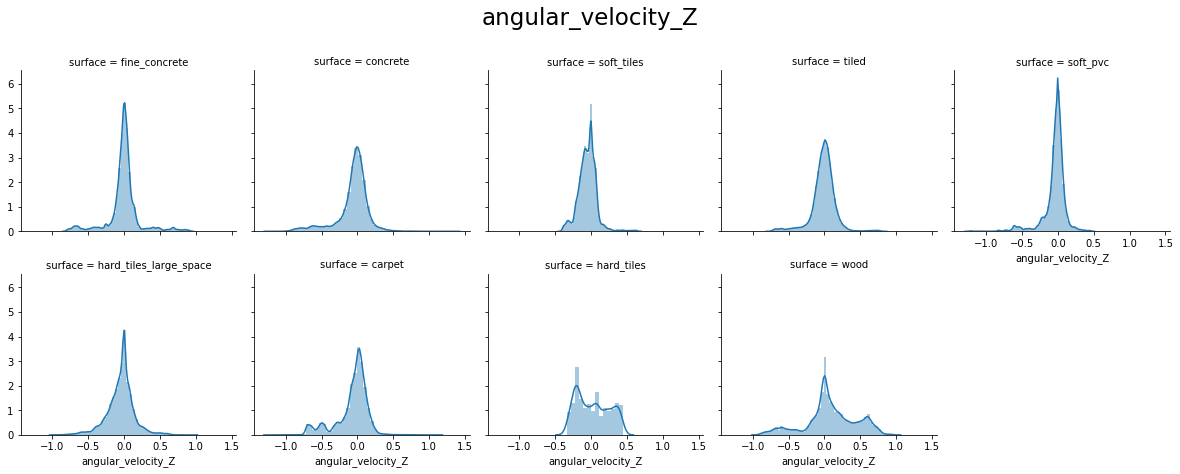

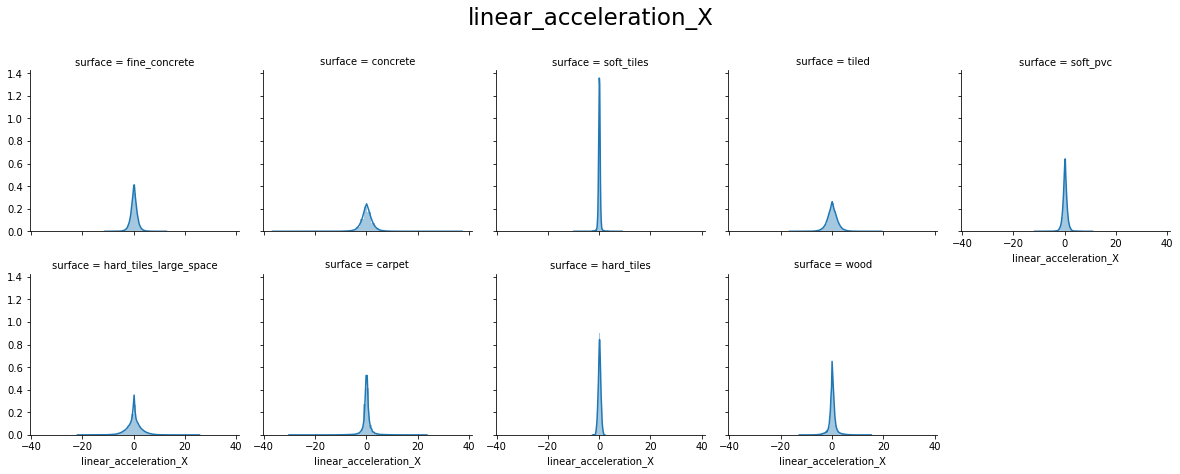

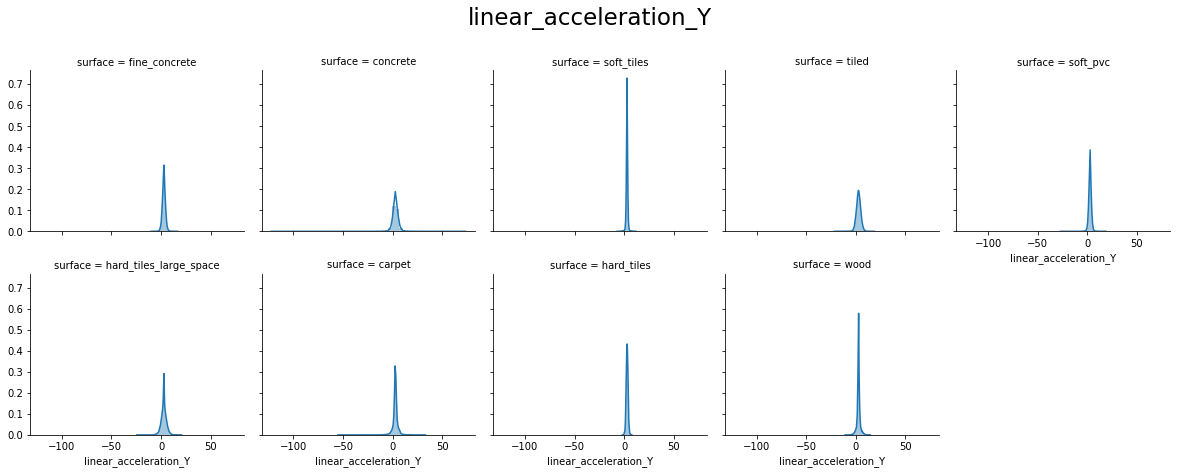

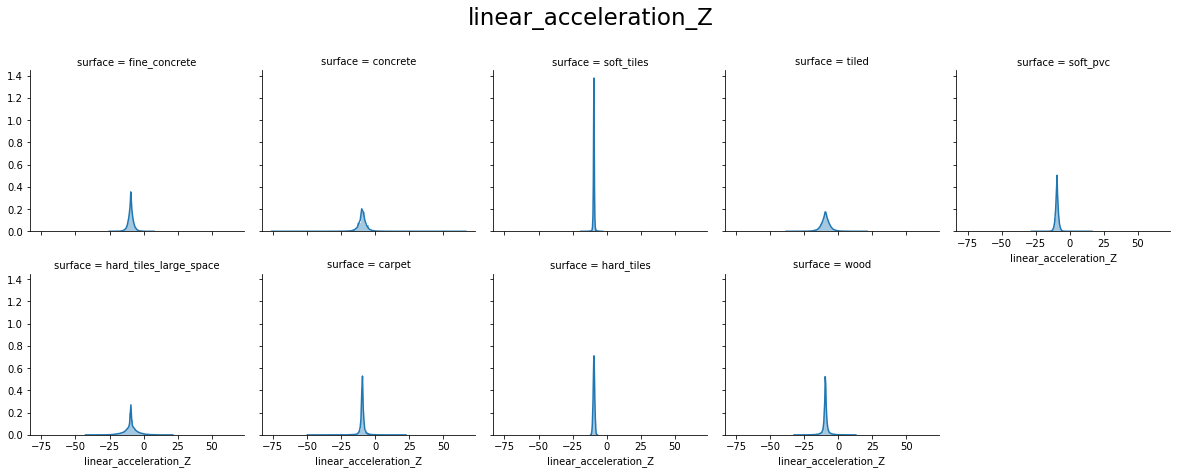

In [7]:
plt.subplots_adjust(top=0.8)
for i, col in enumerate(xtrain.columns[3:]):
    g = sns.FacetGrid(train_data, col="surface", col_wrap=5, height=3, aspect=1.1)
    g = g.map(sns.distplot, col)    
    g.fig.suptitle(col, y=1.09, fontsize=23)

From the above plots, we can see that: 

* **orientation X** and **orientation Y** have values around -1.0 to 1.0
* **orientation Z** and **orientation W** have values around -0.15 to 0.15
* For orientation X, Y, Z and W **hard_tiles** have different distribution as compared to others.
* **angular_velocity_x** forms a perfect Normal distribution
* **angular_velocity_y** and **angular_velocity_z** have distributions close to a Normal for most surfaces, excepts for **hard_tiles**, **carpet** and **wood**.
* **linear_acceleration_X**, **linear_acceleration_Y** and **linear_acceleration_Z** forms a Normal distribution for all surfaces.


## Feature Engineering

To build the ML model we'll convert each time series values to the following metrics:
* Mean
* Standard Deviation
* Min and Max values
* Kurtosis Coefficient
* Skewness Coefficient
* ??? Diff mean
    * Calculates the difference of a Series element compared with the element in previous row.
* ??? Diff min
* ??? Diff max

In [8]:
# Function that performs all data transformation and pre-processing
def data_preprocessing(df, labeled=False):
    
    # New dataframe that will saves the tranformed data
    X = pd.DataFrame()

    # This list will save the type of surface for each series ID
    Y = []

    # The selected attributes used in training
    selected_attributes = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
                           'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
                           'linear_acceleration_Y', 'linear_acceleration_Z']

    # The total number of series in training data
    total_test_series = len(df.series_id.unique())        

    for series in tqdm(range(total_test_series)):
    #for series in range(total_test_series):
        
        # Filter the series id in the DataFrame
        _filter = df.series_id == series

        # If data with labels
        if labeled:
            # Saves the type of surface for each series ID        
            Y.append((df.loc[_filter, 'surface']).values[0])

        # Compute new values for each attribute
        for attr in selected_attributes:
            
            # Compute a new attribute for each series and save in the X DataFrame
            X.loc[series, attr + '_mean'] = df.loc[_filter, attr].mean()
            X.loc[series, attr + '_std'] = df.loc[_filter, attr].std() 
            X.loc[series, attr + '_min'] = df.loc[_filter, attr].min()
            X.loc[series, attr + '_max'] = df.loc[_filter, attr].max()
            X.loc[series, attr + '_kur'] = df.loc[_filter, attr].kurtosis()
            X.loc[series, attr + '_skew'] = df.loc[_filter,attr].skew()
    
    return X,Y


In [9]:
# Apply the Pre-Processing to train data
X_train, Y_train = data_preprocessing(train_data, labeled=True)

# Here is the result DataFrame
X_train.head()

,orientation_X_mean,orientation_X_std,orientation_X_min,orientation_X_max,orientation_X_kur,orientation_X_skew,orientation_Y_mean,orientation_Y_std,orientation_Y_min,orientation_Y_max,...,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Y_kur,linear_acceleration_Y_skew,linear_acceleration_Z_mean,linear_acceleration_Z_std,linear_acceleration_Z_min,linear_acceleration_Z_max,linear_acceleration_Z_kur,linear_acceleration_Z_skew
0,-0.758666,0.000363,-0.75953,-0.75822,-0.646196,-0.659082,-0.634008,0.000471,-0.63456,-0.63306,...,0.075417,5.3864,-1.075352,-0.364964,-9.320391,1.095040,-12.512,-6.2681,0.532135,0.067391
1,-0.958606,0.000151,-0.95896,-0.95837,-0.642996,-0.397289,0.241867,0.000499,0.24074,0.24270,...,-2.149200,6.6850,-0.575238,-0.183139,-9.388899,2.123065,-16.928,-2.7449,1.356800,-0.126848
2,-0.512057,0.001377,-0.51434,-0.50944,-1.052580,0.151971,-0.846171,0.000785,-0.84779,-0.84490,...,-1.254000,6.2105,-0.584675,-0.266815,-9.395783,1.140267,-12.499,-5.7442,0.446304,0.085877
3,-0.939169,0.000227,-0.93968,-0.93884,-1.078090,-0.096106,0.310140,0.000453,0.30943,0.31147,...,-5.825100,11.7430,-0.900409,-0.117380,-9.451164,3.478530,-19.845,-0.5591,0.670500,-0.210103
4,-0.891301,0.002955,-0.89689,-0.88673,-1.165941,-0.226700,0.428144,0.006165,0.41646,0.43740,...,0.342070,4.8181,-0.657740,-0.534365,-9.349988,0.812585,-10.975,-7.4490,-0.486618,0.106132


In [10]:
# Transform the Y list in an array
Y_train=np.array(Y_train)

# Print the size
X_train.shape, Y_train.shape

((3810, 60), (3810,))

In [39]:
# Apply the Pre-Processing to test data
X_test, _ = data_preprocessing(test_data, labeled=False)

X_test.head()

,orientation_X_mean,orientation_X_std,orientation_X_min,orientation_X_max,orientation_X_kur,orientation_X_skew,orientation_Y_mean,orientation_Y_std,orientation_Y_min,orientation_Y_max,...,linear_acceleration_Y_min,linear_acceleration_Y_max,linear_acceleration_Y_kur,linear_acceleration_Y_skew,linear_acceleration_Z_mean,linear_acceleration_Z_std,linear_acceleration_Z_min,linear_acceleration_Z_max,linear_acceleration_Z_kur,linear_acceleration_Z_skew
0,-0.025810,0.000284,-0.026418,-0.025156,-0.690757,-0.389316,-0.988644,0.000039,-0.98873,-0.98854,...,0.20204,6.3266,0.018061,0.125563,-9.325264,2.267268,-16.3620,-3.9960,0.033811,-0.047728
1,-0.932288,0.000564,-0.933720,-0.931480,-0.393465,-0.763507,0.330271,0.001654,0.32661,0.33227,...,-1.42470,6.5591,-1.062457,-0.389972,-9.345727,1.283607,-13.2470,-3.6473,3.938843,0.686782
2,-0.230186,0.001054,-0.231410,-0.227130,-0.208219,0.935914,0.961448,0.000260,0.96109,0.96217,...,-0.92920,7.9789,-0.319975,0.095312,-9.456413,2.780109,-15.9460,-2.1986,-0.334135,0.134209
3,0.164661,0.001182,0.163320,0.167500,-0.595330,0.762830,0.975293,0.000182,0.97485,0.97551,...,2.32610,3.7314,-0.357765,0.085074,-9.357768,0.525308,-10.5090,-7.8266,0.117266,0.467818
4,-0.253600,0.009763,-0.269380,-0.236370,-1.226878,0.084989,0.955712,0.002578,0.95150,0.96018,...,1.39390,4.1428,-0.637648,0.126542,-9.396443,0.212280,-9.8543,-8.9277,-0.544805,0.369715


print(X_test.shape)

## Modeling

### Using gradient boosting (LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms.

Documentation: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [27]:
# Importing packages
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import lightgbm as lgb

In [46]:
# Create a DF to save the predictions
results = pd.DataFrame()
results['series_id']= np.arange(len(test_data.series_id.unique()))

# Create a dictionary that saves the model create in each fold
models = {}

In [49]:
# Get the labels (concrete, tiled, wood, etc.)
unique_labels=list(train_data.surface.unique())

# The list to save the results for each cross-validation fold
train_results_all=[]
test_results_all=[]

# Use Stratified ShuffleSplit cross-validator
# Provides train/test indices to split data in train/test sets.
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.30,random_state=10)

# Control the number of folds in cross-validation (5 folds)
k=1

# From the generator object gets index for series to use in train and test
for train_index, test_index in sss.split(X_train, Y_train):
    
    print("FOLD :",k)
    
    # Saves the split train/test combinations 
    X_train_cv, X_test_cv = X_train.loc[train_index,:], X_train.loc[test_index,:]
    Y_train_cv, Y_test_cv = Y_train[train_index], Y_train[test_index]
    
    # Create the model
    clf = lgb.LGBMClassifier(objective='multiclass', is_unbalance=True, max_depth=10,
                           learning_rate=0.05, n_estimators=500, num_leaves=30)
    
    # Training the model
    # eval gets the tuple pairs to use as validation sets
    clf.fit(X_train_cv, Y_train_cv,
        eval_set=[(X_train_cv, Y_train_cv), (X_test_cv, Y_test_cv)],
        early_stopping_rounds=60, # stops if 60 consequent rounds without decrease of error
        verbose=False, eval_metric='multi_error')
    
    # Compute the F1 score metric
    x_train_predictions = clf.predict(X_train_cv)
    x_test_predictions = clf.predict(X_test_cv)
    train_f1 = f1_score(Y_train_cv, x_train_predictions, average='weighted', labels = unique_labels)
    test_f1 = f1_score(Y_test_cv, x_test_predictions, average='weighted', labels = unique_labels)
    print("F1 Score Train: ",train_f1)
    print("F1 Score Test : ",test_f1)
    print("****************")
    
    train_results_all.append(train_f1)
    test_results_all.append(test_f1)
    
    # Saving the model
    models[k] = clf

    # Perform preditction for the test dataset using current model
    # Save predictions for the current model (fold)
    results['Fold' + str(k)] = clf.predict(X_test)
    k += 1       
    

FOLD : 1
F1 Score Train:  1.0
F1 Score Test :  0.8442047379032883
****************
FOLD : 2
F1 Score Train:  1.0
F1 Score Test :  0.8506957038766751
****************
FOLD : 3
F1 Score Train:  0.9977500915037207
F1 Score Test :  0.8398307943404295
****************
FOLD : 4
F1 Score Train:  1.0
F1 Score Test :  0.8582146708670695
****************
FOLD : 5
F1 Score Train:  1.0
F1 Score Test :  0.8716383172072495
****************


In [50]:
# Compute the mean F1 score
print("Mean train Score: ",np.mean(train_results_all))
print("Mean test Score:  ",np.mean(test_results_all))

Mean train Score:  0.9995500183007442
Mean test Score:   0.8529168448389424


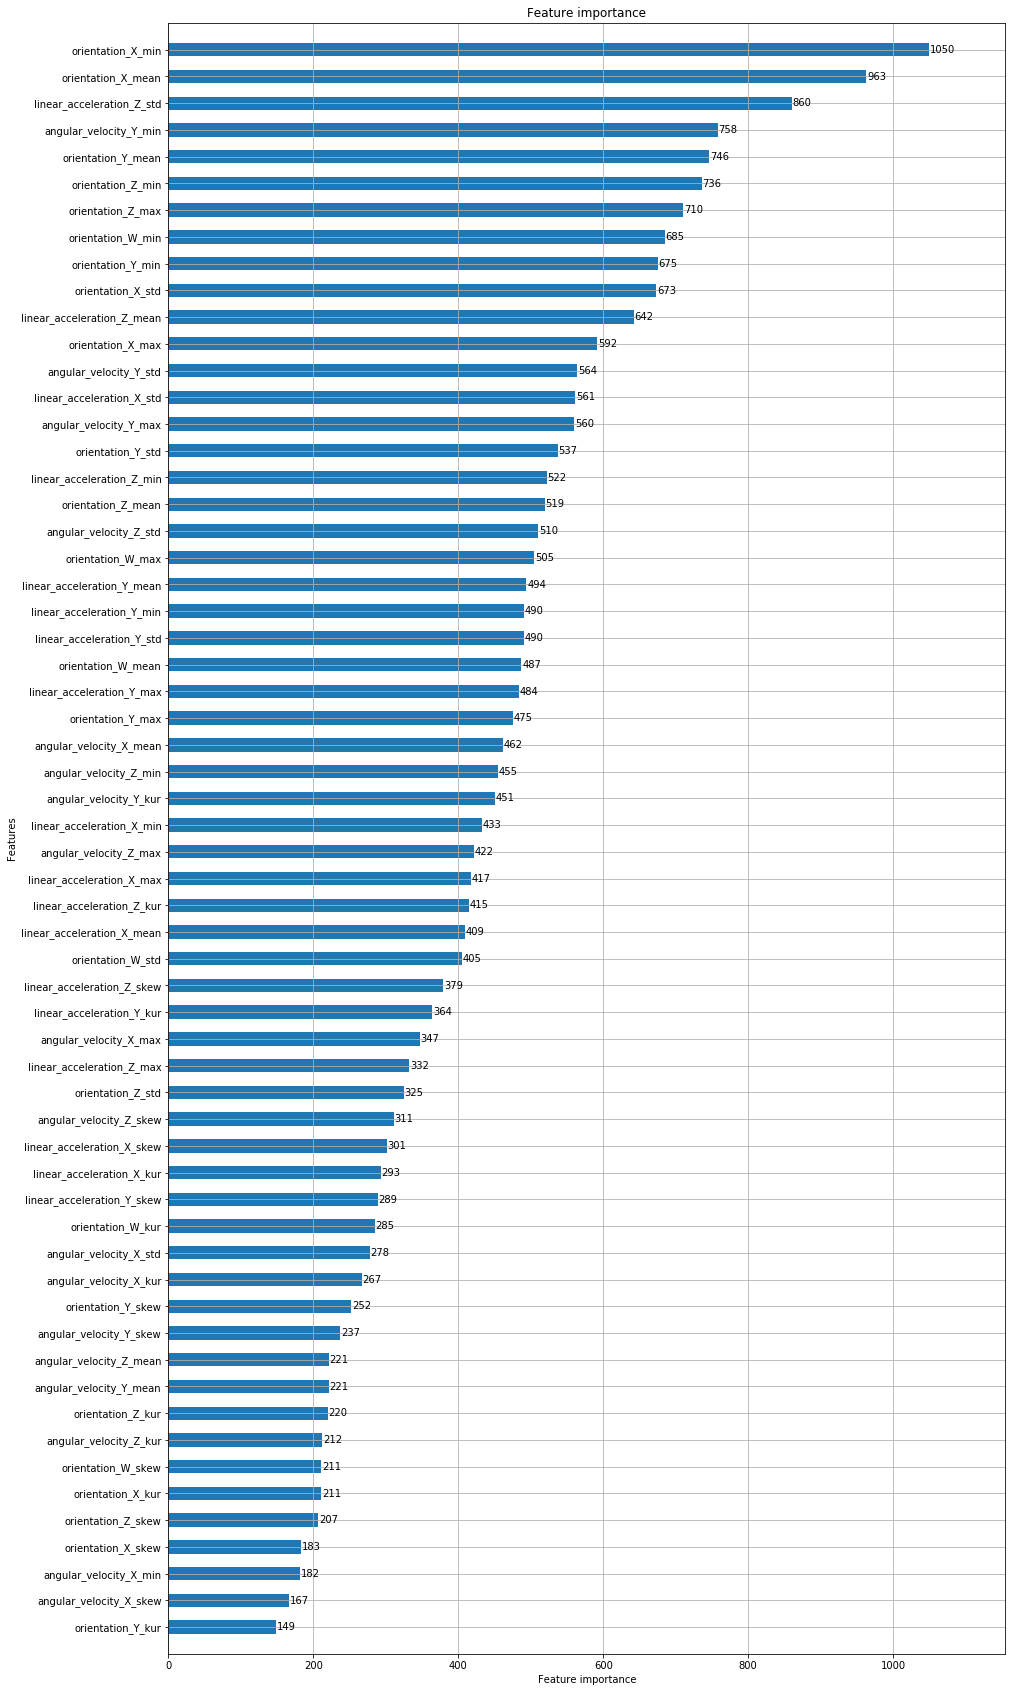

In [52]:
# Plot the Feature Importance for the first model created
plt.figure(figsize=(15,30))
ax=plt.axes()
lgb.plot_importance(models[1], height=0.5, ax=ax)
plt.show()

In [53]:
# Show the results for each model create in each fold
results.head()

,series_id,Fold1,Fold2,Fold3,Fold4,Fold5
0,0,tiled,hard_tiles_large_space,hard_tiles_large_space,hard_tiles_large_space,hard_tiles_large_space
1,1,carpet,concrete,carpet,concrete,concrete
2,2,tiled,tiled,tiled,tiled,tiled
3,3,carpet,soft_tiles,soft_tiles,soft_tiles,carpet
4,4,soft_tiles,soft_tiles,soft_tiles,soft_tiles,soft_tiles


In [54]:
# Compute the mode and save in the column surface
results['surface'] = results.loc[:,['Fold1','Fold2','Fold3','Fold4','Fold5']].mode(axis=1)[0]

In [38]:
# Remove the others columns
del results['Fold1']
del results['Fold2']
del results['Fold3']
del results['Fold4']
del results['Fold5']

In [22]:
print(results.shape)
display(results.head())

(3816, 2)


,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,soft_tiles
4,4,soft_tiles


In [23]:
# Create the submission file
results.to_csv("submission_lgbm.csv",index=False)

In [56]:
# Todo
# Feature selection
# increase the number of features
# Compute accuracy

## References
* https://www.researchgate.net/publication/332799607_Surface_Type_Classification_for_Autonomous_Robot_Indoor_Navigation
* https://www.kaggle.com/c/career-con-2019/overview
* https://www.kaggle.com/c/robotsurface

https://www.kaggle.com/sudeepto22/kernelbb7a9eef90

https://www.kaggle.com/deepdreamx/eda-robot

https://www.kaggle.com/narendrashu/baseline-rf

https://www.kaggle.com/shinjinibasu/helping-robots-full

https://www.kaggle.com/purplejester/pytorch-deep-time-series-classification

https://www.kaggle.com/rijboy/help-robot-navigate-random-forest-fastai
